In [19]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [72]:
len(words)

32033

In [73]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [119]:
# building the dataset
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [120]:
n_embed = 10
n_hidden = 200

In [188]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)  # 27 chars, embedding dim 2
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g)  * 0.2
b1 = torch.randn(n_hidden, generator=g)  * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g)  * 0.01
b2 = torch.randn(vocab_size, generator=g)  * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [189]:
batch_size = 32
max_steps = 200000
lossi = []
for i in range(max_steps):
    # construct a mini-batch of data
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))  # 32 random indices
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch of data
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)  # flatten the batch of embeddings
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)  # batch norm mean
    bnstdi = hpreact.std(0, keepdim=True)  # batch norm std
    hpreact = bngain*(hpreact - bnmeani) / (bnstdi) + bnbias # center the hidden layer pre-activation

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


    h = torch.tanh(hpreact)  # hidden layer activation
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None  # zero the gradients

    # compute gradients
    loss.backward()

    lr = 0.08 if i < 100000 else 0.01  # learning rate schedule
    for p in parameters:
        p.data -= lr * p.grad  # gradient descent step
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
print(loss.item())

      0/200000: 3.3011
  10000/200000: 1.9593
  20000/200000: 2.5039
  30000/200000: 2.0369
  40000/200000: 1.7289
  50000/200000: 2.2299
  60000/200000: 2.1777
  70000/200000: 2.2777
  80000/200000: 1.8482
  90000/200000: 1.8001
 100000/200000: 1.8794
 110000/200000: 2.0694
 120000/200000: 2.4349
 130000/200000: 1.8600
 140000/200000: 2.0119
 150000/200000: 1.8257
 160000/200000: 2.3265
 170000/200000: 2.1778
 180000/200000: 2.4173
 190000/200000: 1.9621
2.261861562728882


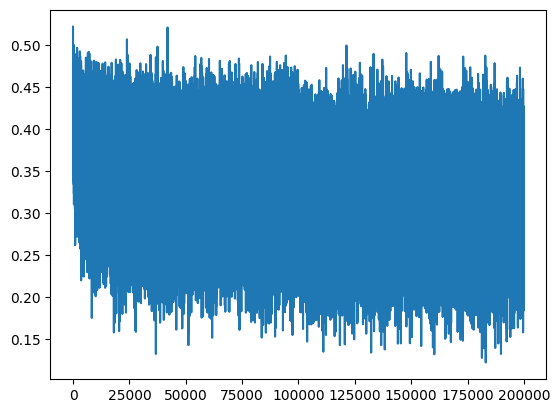

In [190]:
plt.plot(lossi)

In [191]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain*(hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item():.4f}")
split_loss('train')
split_loss('val')

train loss: 2.0602
val loss: 2.1123


In [193]:
# sample from the model
g = torch.Generator().manual_seed(2147483647+ 10)
temperature = 0.3
for i in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1
        hpreact = bngain*(hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        logits = logits / temperature  # scale the logits by temperature
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print(''.join(itos[i] for i in out))

marian
sana
jerman
ana
ari
mari
jara
kalie
kaileigh
mariel
adelin
marianna
kamilah
marianna
gavianna
kalin
jaylen
bran
kaylen
darianna
